In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Generate Events using `numpythia`

In [2]:
from numpythia import Pythia, STATUS, HAS_END_VERTEX, ABS_PDG_ID
import operator
import numpy as np

In [1]:
config_path = 'test.cmnd'

In [3]:
# pythia = Pythia(config_path,
#                verbosity=1)

In [4]:
# selection = ((STATUS == 1) & ~HAS_END_VERTEX & # final state
#             (ABS_PDG_ID != 12) & (ABS_PDG_ID != 14) & (ABS_PDG_ID != 16)) # not a neutrino

In [5]:
# events_particles = []
# events_weights = []
# for event in pythia(events=10): # generate 10 events
#     events_weights.append(event.weights)
#     events_particles.append(event.all())
    
# events_weights = np.array(events_weights)
# events_weights = events_weights.view(
#                     dtype=[(n, 'float64') for n in pythia.weight_labels]
#                 )
# events_particles = np.array(events_particles)

In [6]:
# events_particles.shape # number of events (# of particles per event is variable)

(10,)

In [7]:
# events_particles[0] # all particles in event 0

array([ ( 6500.        ,  0.        ,   0.        ,  6499.99993228,   9.38269998e-01,   0.00000000e+00,  0.        ,  0.        ,  0.        , 2212,  4),
       ( 1430.29555627, -2.49604954,   2.03199668,  1430.29193489,   2.15791864e-05,   0.00000000e+00,  0.        ,  0.        ,  0.        ,    1, 61),
       (  325.36191603,  0.7867963 ,  -3.05682378,   325.34660469,  -5.39479661e-06,   0.00000000e+00,  0.        ,  0.        ,  0.        ,   21, 61),
       ...,
       (   90.20031273, -3.4564092 ,  83.93954889,   -32.83373522,   4.97610000e-01,   0.00000000e+00,  0.        ,  0.        ,  0.        ,  130,  1),
       (   23.46918766, -0.89007211,  21.89382126,    -8.40661238,   0.00000000e+00,  -8.91984030e-05,  0.00236055, -0.00090601,  0.00253003,   22,  1),
       (   50.72976004, -1.72588114,  47.33489652,   -18.16418068,   0.00000000e+00,  -8.91984030e-05,  0.00236055, -0.00090601,  0.00253003,   22,  1)],
      dtype=[('E', '<f8'), ('px', '<f8'), ('py', '<f8'), ('pz', '<f8

In [8]:
# events_weights.shape

(10, 1)

In [9]:
# events_weights['fsr05']

array([[ 0.0511755 ],
       [ 0.0091269 ],
       [ 0.59757694],
       [ 0.00581692],
       [ 0.11621288],
       [ 0.03623035],
       [ 0.56045468],
       [ 0.62498139],
       [ 0.26518123],
       [ 0.17919664]])

# Cluster Jets in the 0th Event using `pyjet`

In [3]:
from pyjet import cluster

In [10]:
# # placeholder
# events_constituents = []

# # loop through events
# for particles in events_particles:
#     # cluster jets using anti_kt(R=0.4)
#     sequence = cluster(particles[['E', 'px', 'py', 'pz']],
#         algo='antikt',
#         ep=True,
#         R=0.4)
#     # remove jets with pt < 10 GeV
#     jets = sequence.inclusive_jets(ptmin=10.0)
#     events_constituents.append([j.constituents() for j in jets[0:2]])

# events_constituents = np.array(events_constituents)


In [11]:
# events_constituents is an array of dimensions (n_events, 2=n_jets)
# each entry is a list of constituents of type PseudoJet

In [4]:
def _properties(constituents):
    '''
    Arguments:
    ----------
        constituents: iterable of objects of type PseudoJet
        (see http://fastjet.fr/repo/doxygen-3.0.0/classfastjet_1_1PseudoJet.html)

    Returns:
    --------
        recarray of constituents' properties: e, et, eta, mass, phi, pt, px, py, pz
    '''
# 	return np.array(
# 		[np.array([c.e, c.et, c.eta, c.mass, c.phi, c.pt, c.px, c.py, c.pz])
# 			for c in constituents]).view(dtype=[(l, 'float64')
# 				for l in ('E', 'Et', 'eta', 'm', 'phi', 'pt', 'px', 'py', 'pz')])
    return np.array([np.array([c.e, c.et, c.eta, c.mass, c.phi, c.pt, c.px, c.py, c.pz]) 
            for c in constituents])

In [993]:
def _padded(properties, max_len=50, n_properties=9):
    '''
    Arguments:
    ----------
        
    Returns:
    --------
    '''
    data = np.zeros((2, max_len, n_properties))
    lengths = []
    ntracks = []
    
    for i, jet in enumerate(properties):
    
        # take all particles unless there are more than max_len 
        nparticles = jet.shape[0] 
        ntracks.append(nparticles)
        data[i, :(min(nparticles, max_len)), :] = jet[:(min(nparticles, max_len)), :] 
        lengths.append(min(nparticles, max_len))
        
    return data, lengths, ntracks

In [994]:
def get_leadingjets_constituents(events_particles, jet_ptmin, max_len=50):
    '''
    Arguments:
    ----------
        events_particles:
        jet_ptmin:

    Returns:
    --------
        numpy array of shape (n_events, 2) where every jet entry is a list of
        constituents' kinematic properties
    '''
    # placeholder
    events_constituents = []
    events_lengths = []
    events_nparticles = []

    # loop through events
    for particles in events_particles:
        # cluster jets using anti_kt(R=0.4)
        sequence = cluster(particles[['E', 'px', 'py', 'pz']],
            algo='antikt',
            ep=True,
            R=0.4)
        # remove jets with pt < 10 GeV
        jets = sequence.inclusive_jets(ptmin=jet_ptmin)
        data, lengths, nparticles = _padded(
            [_properties(
                sorted(
                    j.constituents(), key=operator.attrgetter('pt'), reverse=True)
                ) for j in jets[0:2]
            ], max_len=max_len
        )
        events_constituents.append(data)
        events_lengths.append(lengths)
        events_nparticles.append(nparticles)

    return np.array(events_constituents), np.array(events_lengths), np.array(events_nparticles)

In [95]:
# constituents, lengths = get_leadingjets_constituents(events_particles, 10.0)

In [96]:
# lengths.shape

In [97]:
# constituents.shape

In [98]:
# leading_jet = np.squeeze(constituents[:, 0, :, :])
# subleading_jet = np.squeeze(constituents[:, 1, :, :])

In [99]:
# print leading_jet.shape, subleading_jet.shape

In [100]:
# # sort the data by length of sequence in decreasing order (because PyTorch)
# leading_jet = leading_jet[np.argsort(lengths[:, 0])[::-1]]
# subleading_jet = subleading_jet[np.argsort(lengths[:, 1])[::-1]]

In [995]:
def generate_events(config_path, nevents):
    '''
    Arguments:
    ----------
        config_path:
        nevents:

    Returns:
    --------
        events_particles:
        events_weights:
    '''
    pythia = Pythia(config_path, verbosity=1)
    variations = pythia.weight_labels

    # only consider final state particles that are not neutrinos
    selection = ((STATUS == 1) & ~HAS_END_VERTEX & # final state
        (ABS_PDG_ID != 12) & (ABS_PDG_ID != 14) & (ABS_PDG_ID != 16)) # not a neutrino

    # placeholders for particles and weights
    events_particles = []
    events_weights = []
    # generate events from pythia
    for event in pythia(events=nevents):
        events_weights.append(event.weights)
        events_particles.append(event.all(selection))
    # convert to numpy arrays for usability
    events_weights = np.array(events_weights)
    events_weights = events_weights.view(
                        dtype=[(n, 'float64') for n in variations])
    events_particles = np.array(events_particles)

    return events_particles, events_weights

# Data Preparation in PyTorch

Data handling in PyTorch recommends using a Dataset with a DataLoader. See <a href="http://pytorch.org/tutorials/beginner/data_loading_tutorial.html">this</a> for instructions.

> `torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

> `__len__` so that `len(dataset)` returns the size of the dataset.

> `__getitem__` to support the indexing such that `dataset[i]` can be used to get iith sample

In [1044]:
MAX_LENGTH = 150

In [1045]:
from torch.utils.data import Dataset, DataLoader
class DijetDataset(Dataset):
    '''
    Dataset of jet components for leading and subleading jet in QCD events.
    '''
    def __init__(self, config_path, nevents=100, max_len=50):
        self.nevents = nevents
        particles, self.weights = generate_events(config_path, nevents)
        constituents, lengths, self.nparticles = get_leadingjets_constituents(particles, jet_ptmin=10.0,
                                                            max_len=max_len)
        self.leading_jet = np.squeeze(constituents[:, 0, :, :])
        self.subleading_jet = np.squeeze(constituents[:, 1, :, :])
        
        # sort the data by length of sequence in decreasing order (because PyTorch)
#         self.leading_jet = leading_jet[np.argsort(lengths[:, 0])[::-1]]
#         self.subleading_jet = subleading_jet[np.argsort(lengths[:, 1])[::-1]]
#         self.sorted_lengths = np.sort(lengths, axis=0)[::-1]
#         self.sortback_leading = np.argsort([np.argsort(lengths[:, 0])[::-1]])[0]
#         self.sortback_subleading = np.argsort([np.argsort(lengths[:, 1])[::-1]])[0]
        
        self.lengths = lengths
        
        
    def __len__(self):
        return self.nevents

    def __getitem__(self, idx):
        sample = {
            'leading_jet': self.leading_jet[idx],
            'subleading_jet': self.subleading_jet[idx],
#             'sorted_lengths': self.sorted_lengths[idx],
            'unsorted_lengths': self.lengths[idx],
            'nparticles': self.nparticles[idx]
#             'sortback_leading': self.sortback_leading[idx],
#             'sortback_subleading': self.sortback_subleading[idx],
            
        }
        sample.update({
            'weights_' + name: self.weights[name][idx] for name in self.weights.dtype.names})
        return sample

In [ ]:
d = DijetDataset(config_path, nevents=100000, max_len=MAX_LENGTH) # 1 min for 1000 events
# 8 min for 10000

In [ ]:
d_val = DijetDataset(config_path, nevents=10000, max_len=MAX_LENGTH) # 1 min for 1000 events

In [ ]:
d[:].keys()

In [667]:
d[:]['leading_jet'].shape # jets, particles per jet, features per particle

(10000, 300, 9)

In [1048]:
BATCH_SIZE=128

In [ ]:
dataloader = DataLoader(d,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4)

In [ ]:
dataloader_val = DataLoader(d_val,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=4)

In [259]:
for i_batch, sample_batched in enumerate(dataloader):
    # print weights of 0th batch
    if i_batch==0:
        print sample_batched['weights_fsr05']


 1.9366e-02
 1.2948e-01
 3.3414e-02
 1.5622e-03
 4.5548e-02
 1.3845e-01
 1.5717e-01
 1.5082e-02
 1.6204e-02
 5.7980e-02
 1.4440e-03
 1.8171e-04
 1.3822e-04
 1.5288e-03
 5.8895e-02
 3.1563e-02
 2.9186e-03
 1.5590e+00
 2.9707e-01
 1.6182e-02
 2.3519e-03
 1.0710e-01
 2.4909e-01
 4.7839e-01
 3.9020e+01
 8.4729e-04
 2.8976e-02
 9.5311e-02
 2.5879e+00
 2.8039e-02
 1.4399e-01
 9.1540e-02
 1.0548e-02
 8.5362e-02
 3.1885e-03
 2.1242e-02
 7.2884e-02
 5.0767e+00
 1.4657e+00
 9.2939e-03
 1.6129e-02
 1.6051e-05
 1.3261e-02
 5.2461e-04
 1.3423e-02
 7.5711e-02
 1.2381e-03
 1.1412e-01
 1.2607e-04
 1.5358e-03
 2.2714e-01
 2.1614e-03
 4.6583e-02
 4.8336e-02
 2.1536e-01
 1.5002e-05
 2.1996e-01
 5.2329e-03
 1.4325e-03
 7.7546e-02
 2.7972e-02
 2.2309e-01
 1.8042e-02
 6.3405e-01
 6.3567e-02
 4.1554e-01
 1.0382e+00
 3.4500e-02
 5.8565e-04
 1.5143e-01
 1.4190e+01
 4.9398e+00
 3.7778e-02
 2.2426e-02
 5.7476e-02
 3.0747e-04
 2.8809e-03
 3.2557e-02
 4.1948e-02
 6.0780e-01
 7.1541e-04
 1.5214e-01
 2.0482e-01
 6.

## Data Exploration

Visualize kinematic variables for 1st particle in leading jet, weighted appropriately to distinguish the two datasets.

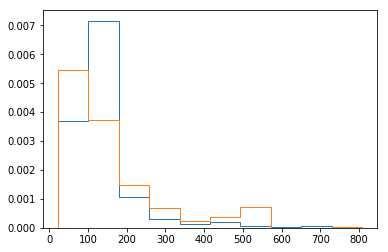

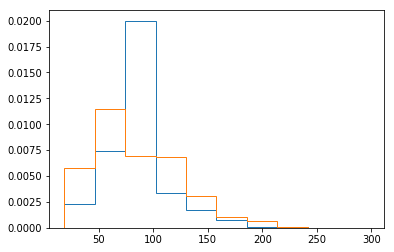

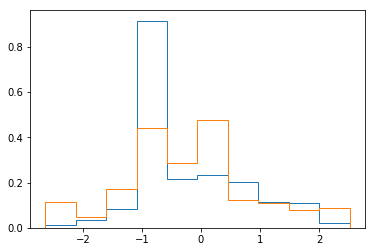

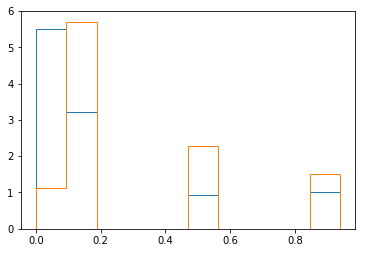

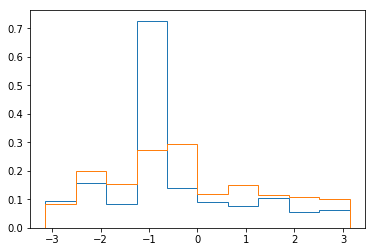

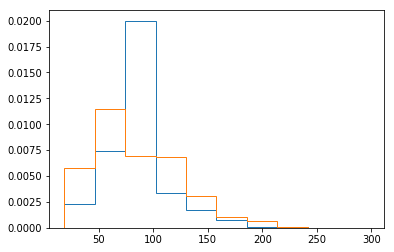

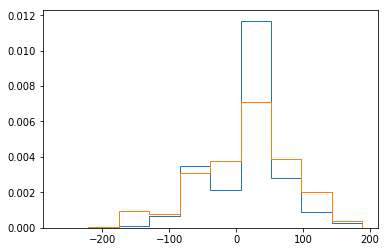

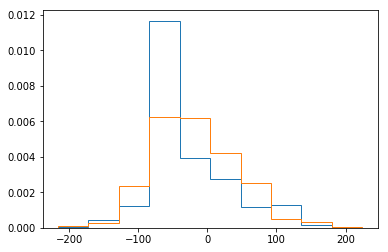

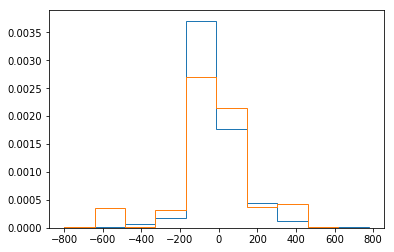

In [260]:
for i in range(9):
    plt.hist(d[:]['leading_jet'][:, 1, i], weights=d[:]['weights_fsr20'],
            histtype='step', normed=True)
    plt.hist(d[:]['leading_jet'][:, 1, i], weights=d[:]['weights_fsr05'],
            histtype='step', normed=True)
    plt.show()

# PyTorch Model

In [523]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [530]:
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# class DoubleLSTM(nn.Module):

#     def __init__(self, input_size, output_size, num_layers, dropout, bidirectional,
#                  batch_size, tagger_output_size, dim_b, dim_c):
#         super(DoubleLSTM, self).__init__()
        
#         # members
#         self.input_size = input_size
#         self.output_size = output_size
#         self.num_layers = num_layers
#         self.num_directions = 2 if bidirectional else 1
#         self.batch_size = batch_size
#         self.dim_b = dim_b
#         self.dim_c = dim_c
        
#         # LSTM layers
#         self.lstm_lead = nn.LSTM(input_size=input_size, hidden_size=output_size,
#                                  num_layers=num_layers, batch_first=True,
#                                  dropout=dropout, bidirectional=bidirectional)
        
#         self.lstm_sublead = nn.LSTM(input_size=input_size, hidden_size=output_size,
#                                     num_layers=num_layers, batch_first=True,
#                                     dropout=dropout, bidirectional=bidirectional)
        
#         # minibatch discimination
#         self.minibatch_tensor = nn.Parameter(self.init_minibatch(), requires_grad=True)
        
#         # output dense layer
#         self.dense = nn.Linear(
#             #output_size * self.num_directions * 2 + # for lstm concat
#                             dim_b,
#                             tagger_output_size)
# #         self.dense = nn.Linear(output_size * self.num_directions * 2 + dim_b,
# #                                32)
# #         self.dense0 = nn.Linear(32,
# #                                16)
# #         self.dense1 = nn.Linear(16,
# #                                tagger_output_size)


#     def init_hidden(self, batch_size):
#         '''
#         Initialize LSTM hidden states to zero at the beginning of each new sequence
#         '''
#         return (Variable(torch.zeros(
#                     self.num_layers * self.num_directions,
#                     batch_size, 
#                     self.output_size), requires_grad=False),
#                 Variable(torch.zeros(
#                     self.num_layers * self.num_directions,
#                     batch_size,
#                     self.output_size), requires_grad=False)
#                )
    
#     def init_minibatch(self):
#         return torch.randn(self.output_size * self.num_directions * 2, # 2 = n_streams
#                           self.dim_b * self.dim_c)


#     def forward(self, leading_jets, subleading_jets, lengths, weights):
        
#         # initialize LSTM hidden states to erase history of previous sequence
#         hidden_lead = self.init_hidden(leading_jets.shape[0])
#         hidden_sublead = self.init_hidden(subleading_jets.shape[0])
        
# #         print lengths
#         # sort the data by length of sequence in decreasing order (because PyTorch)
#         leading_jets = leading_jets[np.argsort(lengths[:, 0])[::-1]]
#         subleading_jets = subleading_jets[np.argsort(lengths[:, 1])[::-1]]
#         sorted_lengths = np.sort(lengths, axis=0)[::-1]
#         sortback_leading = np.argsort([np.argsort(lengths[:, 0])[::-1]])[0]
#         sortback_subleading = np.argsort([np.argsort(lengths[:, 1])[::-1]])[0]
# #         print sorted_lengths

#         # pack sequences
#         packed_leading_jets = nn.utils.rnn.pack_padded_sequence(
#             leading_jets, batch_first=True, lengths=sorted_lengths[:, 0]
#         )
#         packed_subleading_jets = nn.utils.rnn.pack_padded_sequence(
#             subleading_jets, batch_first=True, lengths=sorted_lengths[:, 1]
#         )   
#         # LSTMs
#         lstm_lead_out, self.hidden_lead = self.lstm_lead(
#             packed_leading_jets, hidden_lead)
#         lstm_sublead_out, self.hidden_sublead = self.lstm_sublead(
#             packed_subleading_jets, hidden_sublead)
               
#         # unpack sequences
#         lstm_lead_out_1, _ = pad_packed_sequence(lstm_lead_out, batch_first=True)
#         lstm_sublead_out_1, _ = pad_packed_sequence(lstm_sublead_out, batch_first=True)

#         # sort back
#         lstm_lead_out_2 = lstm_lead_out_1[sortback_leading]
# #         lstm_lead_out = lstm_lead_out[:, -1, :] # only last timestep output
#         lstm_sublead_out_2 = lstm_sublead_out_1[sortback_subleading]
# #         lstm_sublead_out = lstm_sublead_out[:, -1, :] # only last timestep output
        
#         # return output of last timestep (not full sequence)
#         idx_lead = Variable(
#             torch.from_numpy(lengths[:, 0] - 1).type(torch.LongTensor),
#             requires_grad=False).view(-1, 1).expand(lstm_lead_out_2.size(0), lstm_lead_out_2.size(2)).unsqueeze(1)
#         lstm_lead_out_3 = lstm_lead_out_2.gather(1, idx_lead).squeeze()
#         idx_sublead = Variable(
#             torch.from_numpy(lengths[:, 1] - 1).type(torch.LongTensor),
#             requires_grad=False).view(-1, 1).expand(lstm_sublead_out_2.size(0), lstm_sublead_out_2.size(2)).unsqueeze(1)
#         lstm_sublead_out_3 = lstm_sublead_out_2.gather(1, idx_sublead).squeeze()
        
        
#         # concatenate outputs of the 2 LSTMs
#         merge = torch.cat([lstm_lead_out_3, lstm_sublead_out_3], 1)

#         # minibatch discrimination (from AaronYALai)
#         minibatch_matrix_ = merge.mm(self.minibatch_tensor)
#         minibatch_matrix = minibatch_matrix_.view(-1, self.dim_b, self.dim_c)
#         out_tensor = []
#         for i in range(minibatch_matrix.size()[0]): # loop thru examples in batch size
#             out_i = None
#             for j in range(minibatch_matrix.size()[0]): # loop thru examples in batch size
#                 o_i = torch.sum(
#                     torch.abs(minibatch_matrix[i, :, :] - minibatch_matrix[j, :, :]), 1)
#                 o_i = torch.exp(-o_i)
#                 if out_i is None:
#                     out_i = o_i * Variable(weights[j], requires_grad=False).type(torch.FloatTensor)
#                 else:
#                     out_i = out_i + o_i * Variable(weights[j], requires_grad=False).type(torch.FloatTensor)
#             out_tensor.append(out_i * Variable(weights[i], requires_grad=False).type(torch.FloatTensor))
#             # out_i is of dimensions B
        
#         # out_tensor is a list of len = batch_size of tensors of dim B
#         self.minibatch_out_pre = torch.cat(tuple(out_tensor)).view(
#             minibatch_matrix.size()[0], self.dim_b)
#         # minibatch_out is [batch_size, B]
#         #merge = torch.cat((merge, minibatch_out), 1)
#         minibatch_out = F.tanh(self.minibatch_out_pre)
# #         merge = minibatch_out
# #         self.pre_fc = merge
#         # output layer
# #         h = F.relu(self.dense(merge))
# #         h = F.relu(self.dense0(h))
# #         outputs = F.sigmoid(self.dense1(h))
# #         outputs = F.sigmoid(self.dense(minibatch_out)) #merge))
#         outputs = self.dense(minibatch_out)
#         return outputs

In [863]:
def train_on_batch(model, optimizer, epoch, batch_idx, data, name_weights):
    
    leading_input = Variable(data['leading_jet'].type(torch.FloatTensor), requires_grad=False)
    subleading_input = Variable(data['subleading_jet'].type(torch.FloatTensor), requires_grad=False)
    unsorted_lengths = data['unsorted_lengths'].numpy()
    weights = torch.log(data[name_weights] / 1e-1).type(torch.FloatTensor)
    
    batch_size = leading_input.shape[0]

    batch_weights = Variable(
            weights.resize_(1, batch_size),
            requires_grad=False) / torch.sum(weights) # normalized

    optimizer.zero_grad()
    predictions = model(leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size)

    if name_weights == 'weights_fsr20':
        targets = Variable(torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
                          requires_grad=False)
    elif name_weights == 'weights_fsr05':
        targets = Variable(torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
                          requires_grad=False)
    else:
        raise ValueError
        
    loss_function = nn.BCEWithLogitsLoss() #nn.BCELoss() #weight=batch_weights)
    loss = loss_function(predictions, targets)
    loss.backward()
    optimizer.step()
    
    batch_weighted_loss = loss * batch_size # to compute per epoch loss

    if batch_idx % 5 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch,
            dataloader.batch_size * batch_idx + len(data['leading_jet']),
            len(dataloader.dataset),
            100 * (dataloader.batch_size * batch_idx + len(data['leading_jet'])) / len(dataloader.dataset),
            loss.data[0]))
    return batch_weighted_loss, np.array(model.dense.weight.data.numpy()[0]) # for debugging purposes

In [532]:
# model = DoubleLSTM(input_size=9,
#                    output_size=32,
#                    num_layers=1,
#                    dropout=0.1,
#                    bidirectional=False,
#                    batch_size=BATCH_SIZE,
#                    tagger_output_size=1,
#                    dim_b=12, dim_c=16)

In [533]:
# model

DoubleLSTM(
  (lstm_lead): LSTM(9, 32, batch_first=True, dropout=0.1)
  (lstm_sublead): LSTM(9, 32, batch_first=True, dropout=0.1)
  (dense): Linear(in_features=12, out_features=1)
)

In [534]:
# # binary cross entropy
# # loss_function = nn.BCELoss()
# # loss_function = F.binary_cross_entropy()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

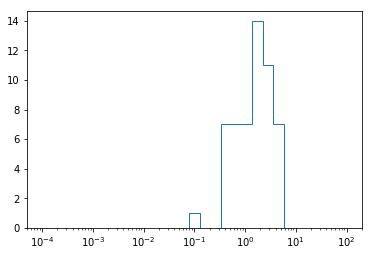

In [379]:
# plt.hist(np.log((data['weights_fsr20'] / 1e-1).numpy()), histtype='step', bins=np.logspace(-4, 2, 30))
# # plt.hist((data['weights_fsr05']).numpy(), histtype='step', bins=np.logspace(-5, 1, 30))
# plt.xscale('log')

In [535]:
# # Does it make sense to have the same batch of examples be shown for the two datasets?
# model.train()
# # f = plt.figure(figsize=(8,8))
# l05 = []
# l20 = []
# for epoch in range(BATCH_SIZE * i_batch): #1
#     for batch_idx, data in enumerate(dataloader):
#         #print 'mu_R FSR = 0.5'
#         last_layer_weights05 = train_on_batch(model, optimizer, epoch, batch_idx, data,
#               'weights_fsr05'
#              )
#         #print 'mu_R FSR = 2.0'
#         last_layer_weights20 = train_on_batch(model, optimizer, epoch, batch_idx, data,
#               'weights_fsr20'
#              )
#     l05.append(last_layer_weights05) # look at weights in last layer from last batch of samples over time (epochs)
#     l20.append(last_layer_weights20)
# # plt.plot(last_layer_weights05, color='blue', alpha=1 - 1./(1+epoch), label='0.5 - epoch: {}'.format(epoch))
# # plt.plot(last_layer_weights20, color='orange', alpha=1 - 1./(1+epoch), label='2.0 - epoch: {}'.format(epoch))

# # plt.legend()
# # plt.show()

Train Epoch: 0 [100/1000 (10%)]	Loss: 0.766643
Train Epoch: 0 [100/1000 (10%)]	Loss: 0.643583
Train Epoch: 0 [600/1000 (60%)]	Loss: 0.752527
Train Epoch: 0 [600/1000 (60%)]	Loss: 0.655187
Train Epoch: 1 [100/1000 (10%)]	Loss: 0.742292
Train Epoch: 1 [100/1000 (10%)]	Loss: 0.664098
Train Epoch: 1 [600/1000 (60%)]	Loss: 0.731081
Train Epoch: 1 [600/1000 (60%)]	Loss: 0.667343
Train Epoch: 2 [100/1000 (10%)]	Loss: 0.723384
Train Epoch: 2 [100/1000 (10%)]	Loss: 0.685569
Train Epoch: 2 [600/1000 (60%)]	Loss: 0.718917
Train Epoch: 2 [600/1000 (60%)]	Loss: 0.686762
Train Epoch: 3 [100/1000 (10%)]	Loss: 0.712615
Train Epoch: 3 [100/1000 (10%)]	Loss: 0.684767
Train Epoch: 3 [600/1000 (60%)]	Loss: 0.705557
Train Epoch: 3 [600/1000 (60%)]	Loss: 0.690034
Train Epoch: 4 [100/1000 (10%)]	Loss: 0.708136
Train Epoch: 4 [100/1000 (10%)]	Loss: 0.692261
Train Epoch: 4 [600/1000 (60%)]	Loss: 0.703042
Train Epoch: 4 [600/1000 (60%)]	Loss: 0.692578
Train Epoch: 5 [100/1000 (10%)]	Loss: 0.706714
Train Epoch: 

Process Process-6252:
Process Process-6251:
Process Process-6249:
Process Process-6250:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing

KeyboardInterrupt: 

In [866]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class DoubleLSTM(nn.Module):

    def __init__(self, input_size, output_size, num_layers, dropout, bidirectional,
                 batch_size, tagger_output_size):
        super(DoubleLSTM, self).__init__()
        
        # members
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.batch_size = batch_size

        # LSTM layers
        self.lstm_lead = nn.LSTM(input_size=input_size, hidden_size=output_size,
                                 num_layers=num_layers, batch_first=True,
                                 dropout=dropout, bidirectional=bidirectional)
        
        self.lstm_sublead = nn.LSTM(input_size=input_size, hidden_size=output_size,
                                    num_layers=num_layers, batch_first=True,
                                    dropout=dropout, bidirectional=bidirectional)
        
        # output dense layer
        self.dense = nn.Linear(
            # multiple is because we have a max pool, min, avg
            4 * (output_size * self.num_directions * 2), #+ # for lstm concat
#             1 * (output_size * self.num_directions * 2), #+ # for lstm concat
#             dim_b,
            tagger_output_size)
        
#         self.dense = nn.Linear(output_size * self.num_directions * 2 + dim_b,
#                                32)
#         self.dense0 = nn.Linear(32,
#                                16)
#         self.dense1 = nn.Linear(16,
#                                tagger_output_size)


    def init_hidden(self, batch_size):
        '''
        Initialize LSTM hidden states to zero at the beginning of each new sequence
        '''
        return (Variable(torch.zeros(
                    self.num_layers * self.num_directions,
                    batch_size, 
                    self.output_size), requires_grad=False),
                Variable(torch.zeros(
                    self.num_layers * self.num_directions,
                    batch_size,
                    self.output_size), requires_grad=False)
               )
    
    def init_batch_dense(self, batch_size):
        a = torch.Tensor(1, batch_size)
        return torch.nn.init.normal(a)


    def forward(self, leading_jets, subleading_jets, lengths, batch_weights, batch_size):
                
        # initialize LSTM hidden states to erase history of previous sequence
        hidden_lead = self.init_hidden(batch_size)
        hidden_sublead = self.init_hidden(batch_size)
        
        # sort the data by length of sequence in decreasing order (because PyTorch)
        leading_jets = leading_jets[np.argsort(lengths[:, 0])[::-1]]
        subleading_jets = subleading_jets[np.argsort(lengths[:, 1])[::-1]]
        sorted_lengths = np.sort(lengths, axis=0)[::-1]
        sortback_leading = np.argsort([np.argsort(lengths[:, 0])[::-1]])[0]
        sortback_subleading = np.argsort([np.argsort(lengths[:, 1])[::-1]])[0]

        # pack sequences
        packed_leading_jets = nn.utils.rnn.pack_padded_sequence(
            leading_jets, batch_first=True, lengths=sorted_lengths[:, 0]
        )
        packed_subleading_jets = nn.utils.rnn.pack_padded_sequence(
            subleading_jets, batch_first=True, lengths=sorted_lengths[:, 1]
        )   
        # LSTMs
        lstm_lead_out, self.hidden_lead = self.lstm_lead(
            packed_leading_jets, hidden_lead)
        lstm_sublead_out, self.hidden_sublead = self.lstm_sublead(
            packed_subleading_jets, hidden_sublead)
               
        # unpack sequences
        lstm_lead_out_1, _ = pad_packed_sequence(lstm_lead_out, batch_first=True)
        lstm_sublead_out_1, _ = pad_packed_sequence(lstm_sublead_out, batch_first=True)

        # sort back
        lstm_lead_out_2 = lstm_lead_out_1[sortback_leading]
#         lstm_lead_out = lstm_lead_out[:, -1, :] # only last timestep output
        lstm_sublead_out_2 = lstm_sublead_out_1[sortback_subleading]
#         lstm_sublead_out = lstm_sublead_out[:, -1, :] # only last timestep output
        
        # return output of last timestep (not full sequence)
        idx_lead = Variable(
            torch.from_numpy(lengths[:, 0] - 1).type(torch.LongTensor),
            requires_grad=False).view(-1, 1).expand(lstm_lead_out_2.size(0), lstm_lead_out_2.size(2)).unsqueeze(1)
        lstm_lead_out_3 = lstm_lead_out_2.gather(1, idx_lead).squeeze()
        idx_sublead = Variable(
            torch.from_numpy(lengths[:, 1] - 1).type(torch.LongTensor),
            requires_grad=False).view(-1, 1).expand(lstm_sublead_out_2.size(0), lstm_sublead_out_2.size(2)).unsqueeze(1)
        lstm_sublead_out_3 = lstm_sublead_out_2.gather(1, idx_sublead).squeeze()
        
        # concatenate outputs of the 2 LSTMs
        merge = torch.cat([lstm_lead_out_3, lstm_sublead_out_3], 1)

#         batch_weights = Variable(
#             weights.resize_(1, batch_size),
#             requires_grad=False) / torch.sum(weights)
#         batch_features = self.batch_dense.mm(merge).expand(batch_size, merge.shape[-1])
        batch_features = batch_weights.mm(merge).expand(batch_size, merge.shape[-1])
        
        weighted_mult = batch_weights.transpose(0, 1).expand(-1, merge.shape[-1]) * merge
        maxpool = torch.max(weighted_mult, 0)[0].expand(batch_size, -1)
        minpool = torch.min(weighted_mult, 0)[0].expand(batch_size, -1)
        avgpool = torch.mean(weighted_mult, 0).expand(batch_size, -1)
        #prod = torch.prod(weighted_mult, 0).expand(batch_size, -1)
        
        batch_features = torch.cat([batch_features, maxpool, minpool, avgpool], 1)#, prod], 1)
        outputs = self.dense(batch_features)
        return outputs
        

In [907]:
model = DoubleLSTM(input_size=9,
                   output_size=32,
                   num_layers=1,
                   dropout=0.1,
                   bidirectional=True,
                   batch_size=BATCH_SIZE,
                   tagger_output_size=1)

In [908]:
model

DoubleLSTM(
  (lstm_lead): LSTM(9, 32, batch_first=True, dropout=0.1, bidirectional=True)
  (lstm_sublead): LSTM(9, 32, batch_first=True, dropout=0.1, bidirectional=True)
  (dense): Linear(in_features=512, out_features=1)
)

In [909]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [910]:
# save out weights in last dense layer for debugging purposes
DEBUG = True
best_loss = float('inf')
wait = 0

if DEBUG:
    l05 = []
    l20 = []
    
# time: 2 min and a half per epoch for training
for epoch in range(30): # n_epochs
    
    # training
    model.train()
    
    # initialize per-epoch losses
    batch_weighted_loss05_epoch = 0
    batch_weighted_loss20_epoch = 0
    
    for batch_idx, data in enumerate(dataloader):
        
        batch_weighted_loss05_i, last_layer_weights05 = train_on_batch(
            model, optimizer, epoch, batch_idx, data, 'weights_fsr05'
        )
        
        batch_weighted_loss20_i, last_layer_weights20 = train_on_batch(
            model, optimizer, epoch, batch_idx, data, 'weights_fsr20'
        )
        
        # accumulate per-epoch loss
        batch_weighted_loss05_epoch += batch_weighted_loss05_i
        batch_weighted_loss20_epoch += batch_weighted_loss20_i
        
    if DEBUG:
        l05.append(last_layer_weights05) # look at weights in last layer from last batch of samples over time (epochs)
        l20.append(last_layer_weights20)
        
    print 'Epoch {}: Loss 0.5 = {}; Loss 2.0 = {}; Total = {}'.format(
        epoch,
        batch_weighted_loss05_epoch.data[0] / dataloader.dataset.nevents,
        batch_weighted_loss20_epoch.data[0] / dataloader.dataset.nevents,
        (batch_weighted_loss05_epoch.data[0] + batch_weighted_loss20_epoch.data[0]) / (2 * dataloader.dataset.nevents)
    )
    
    # validate
    model.eval()
    loss_val = 0
    
    for batch_idx_val, data_val in enumerate(dataloader_val):
    
        leading_input = Variable(data_val['leading_jet'].type(torch.FloatTensor))
        subleading_input = Variable(data_val['subleading_jet'].type(torch.FloatTensor))
        unsorted_lengths = data_val['unsorted_lengths'].numpy()
        weights_05 = torch.log(data_val['weights_fsr05'] / 1e-1).type(torch.FloatTensor)
        weights_20 = torch.log(data_val['weights_fsr20'] / 1e-1).type(torch.FloatTensor)
        batch_size = leading_input.shape[0]
        batch_weights_05 = Variable(
                weights_05.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_05) # normalized

        pred05_val = F.sigmoid(
            model(leading_input, subleading_input, unsorted_lengths, batch_weights_05, batch_size))#.data.numpy()
        
        batch_weights_20 = Variable(
                weights_20.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_20) # normalized

        pred20_val = F.sigmoid(
            model(leading_input, subleading_input, unsorted_lengths, batch_weights_20, batch_size))#.data.numpy()
        
        targets_05 = Variable(
            torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
            requires_grad=False)
        
        targets_20 = Variable(
            torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
            requires_grad=False)
        
        loss_function = nn.BCEWithLogitsLoss() 
        loss_val += (loss_function(pred05_val, targets_05) + loss_function(pred20_val, targets_20)) / 2
    
    loss_val /= (batch_idx_val + 1)
    loss_val = float(loss_val)
    # early stopping
    patience = 5
    if loss_val < best_loss:
        print 'Validation loss improved from {:0.5f} to {:0.5f}'.format(best_loss, loss_val)
        best_loss = loss_val
        wait = 0
        print 'Saving checkpoint at ./checkpoint.pth'
        torch.save(model.state_dict(), 'checkpoint.pth')

    else:
        wait += 1
        if wait >= patience - 1:
            print 'Stopping early.'
            break
    
print 'Restoring best weights from checkpoint at ./checkpoint.pth'
model.load_state_dict(torch.load('checkpoint.pth'))

# plt.plot(last_layer_weights05, color='blue', alpha=1 - 1./(1+epoch), label='0.5 - epoch: {}'.format(epoch))
# plt.plot(last_layer_weights20, color='orange', alpha=1 - 1./(1+epoch), label='2.0 - epoch: {}'.format(epoch))

# plt.legend()
# plt.show()

Train Epoch: 0 [128/10000 (1%)]	Loss: 0.676123
Train Epoch: 0 [128/10000 (1%)]	Loss: 0.697952
Train Epoch: 0 [768/10000 (7%)]	Loss: 0.687698
Train Epoch: 0 [768/10000 (7%)]	Loss: 0.666833
Train Epoch: 0 [1408/10000 (14%)]	Loss: 0.756913
Train Epoch: 0 [1408/10000 (14%)]	Loss: 0.804173
Train Epoch: 0 [2048/10000 (20%)]	Loss: 0.665658
Train Epoch: 0 [2048/10000 (20%)]	Loss: 1.341436
Train Epoch: 0 [2688/10000 (26%)]	Loss: 0.727489
Train Epoch: 0 [2688/10000 (26%)]	Loss: 0.472854
Train Epoch: 0 [3328/10000 (33%)]	Loss: 0.678816
Train Epoch: 0 [3328/10000 (33%)]	Loss: 0.811601
Train Epoch: 0 [3968/10000 (39%)]	Loss: 0.578714
Train Epoch: 0 [3968/10000 (39%)]	Loss: 0.770104
Train Epoch: 0 [4608/10000 (46%)]	Loss: 0.606916
Train Epoch: 0 [4608/10000 (46%)]	Loss: 0.742619
Train Epoch: 0 [5248/10000 (52%)]	Loss: 0.685588
Train Epoch: 0 [5248/10000 (52%)]	Loss: 0.428125
Train Epoch: 0 [5888/10000 (58%)]	Loss: 0.653119
Train Epoch: 0 [5888/10000 (58%)]	Loss: 0.677242
Train Epoch: 0 [6528/10000 (

Process Process-7683:
Process Process-7682:
Process Process-7684:
Process Process-7681:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", l

KeyboardInterrupt: 

Check that gradient and parameters make some sense. The following cell is used to make sure we didn't interrupt the training right after zeroing the gradients.

In [723]:
last_layer_weights05 = train_on_batch(model, optimizer, epoch, batch_idx, data,
              'weights_fsr05'
             )

Train Epoch: 3 [128/10000 (1%)]	Loss: nan


In [750]:
W, b = model.dense.parameters()
print W.grad
print b.grad

Variable containing:

Columns 0 to 9 
1.00000e-02 *
 -0.2187 -1.1057 -0.0559  1.1891  0.8006 -0.1993  1.1216  1.3423 -0.4284  0.0432

Columns 10 to 19 
1.00000e-02 *
  0.4517  0.9838 -1.1347 -0.2377 -0.6425  0.2071 -0.4352 -1.6312  0.7536  2.3986

Columns 20 to 29 
1.00000e-02 *
  0.3707  0.2558 -1.2240  0.0819  0.3575 -0.0648 -0.8140 -1.4302 -1.2220  0.6292

Columns 30 to 39 
1.00000e-02 *
 -0.4097 -0.6013  0.0809 -0.0337 -0.0997 -0.1371 -0.1988 -0.2710  0.0352 -0.4866

Columns 40 to 49 
1.00000e-02 *
 -0.0435  0.2158 -0.3389  0.0414  0.5164 -0.0741  0.0884 -0.3162  0.1431 -0.3423

Columns 50 to 59 
1.00000e-02 *
 -0.4868  0.3050 -0.2833 -0.3657 -0.1919 -0.0154  0.4648  0.0130  0.1827 -0.0609

Columns 60 to 69 
1.00000e-02 *
 -0.0054  0.0276 -0.0887  0.1251  0.4416 -3.4658 -0.9413  0.2601 -0.3571  0.1647

Columns 70 to 79 
1.00000e-02 *
 -0.3595 -1.8541 -0.7639 -3.2050 -1.6065  0.3992  2.1620  0.9603  1.1483 -0.4400

Columns 80 to 89 
1.00000e-02 *
  2.0909  0.9889  0.2135  0.0684  0.

In [751]:
[_.grad for _ in list(model.lstm_lead.parameters())]

[Variable containing:
  3.2188e-05  1.3579e-04  5.8079e-04  ...  -1.3719e-04  7.3636e-05  1.1956e-04
  2.1868e-04  2.3080e-04  3.2546e-04  ...  -1.9798e-04  3.3227e-04 -7.2599e-05
  6.1935e-04  3.1278e-04  6.3901e-04  ...  -3.3986e-05  3.7659e-04  3.8549e-04
                 ...                   ⋱                   ...                
 -4.1898e-04 -2.6851e-04 -2.0620e-03  ...   6.0242e-05 -3.4060e-04 -9.6811e-05
 -1.0885e-04 -8.3296e-05 -6.8179e-04  ...   1.2818e-04 -2.1691e-04 -8.6103e-06
 -2.3272e-04 -1.3176e-04  7.5416e-04  ...   1.1674e-04 -2.6653e-04  3.6721e-05
 [torch.FloatTensor of size 128x9], Variable containing:
  2.9159e-04  1.0555e-04 -2.7541e-05  ...  -2.0123e-04  5.0263e-05 -2.3334e-04
 -1.2441e-04 -1.3817e-04  7.0347e-05  ...   1.5848e-05 -1.1898e-04 -7.1791e-05
 -3.3596e-04 -1.5283e-04  2.6976e-04  ...   5.5161e-04  1.9929e-05  4.9879e-04
                 ...                   ⋱                   ...                
  6.8782e-04  3.3280e-04 -9.5222e-04  ...  -9.5969e-

In [912]:
# difference in dense layer weights (check they are not all identical)
l05[0] - l05[20]

array([ -9.37725604e-03,  -5.38366884e-02,  -9.63518023e-03,
        -1.16272375e-01,   5.62847853e-02,   6.99778795e-02,
        -1.04714729e-01,   8.26478004e-02,  -8.75060260e-03,
         2.16951743e-02,   5.27747720e-02,   1.06863379e-01,
         4.54756767e-02,  -4.19006348e-02,  -3.64307463e-02,
        -1.38723999e-02,   8.23554695e-02,  -5.78934029e-02,
        -4.11904082e-02,   1.04389332e-01,  -3.22944857e-02,
         1.34035885e-01,  -3.42898220e-02,  -1.35915428e-01,
        -3.83783281e-02,  -5.32146990e-02,  -1.93631977e-01,
        -6.88441545e-02,  -4.88718040e-02,   1.29893050e-01,
         2.54209414e-02,  -1.96017474e-02,   8.57286528e-03,
        -1.65328365e-02,   2.97028739e-02,  -1.64088681e-02,
        -3.39476168e-02,   6.25436008e-02,   9.65103041e-03,
         7.56944716e-03,   2.60835588e-02,   4.54643555e-02,
         2.16969475e-03,   3.56648266e-02,  -2.84830127e-02,
         1.08673144e-03,  -1.18123442e-02,  -3.18879038e-02,
         3.12079862e-03,

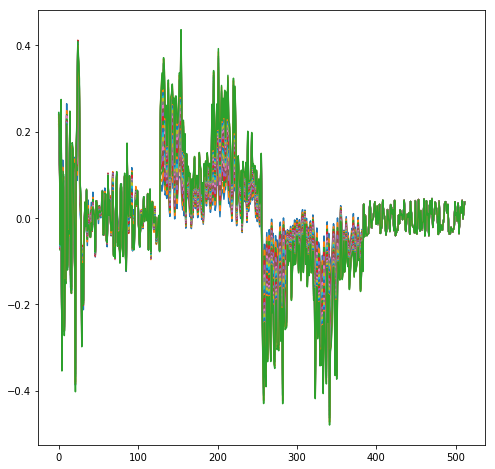

In [913]:
# change of weights in the last dense layer over epochs
plt.figure(figsize=(8,8))
for w in l20:
    plt.plot(w)
plt.show()

## Test performance on a separate test set

In [1059]:
d_test = DijetDataset(config_path, nevents=10000, max_len=MAX_LENGTH) # 1 min for 1000 events

KeyboardInterrupt: 

In [1060]:
dataloader_test = DataLoader(d_test,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=4)

In [1013]:
model.eval()
pred05_test = []
for batch_idx, data in enumerate(dataloader_test):
    leading_input = Variable(data['leading_jet'].type(torch.FloatTensor))
    subleading_input = Variable(data['subleading_jet'].type(torch.FloatTensor))
    unsorted_lengths = data['unsorted_lengths'].numpy()
    weights = torch.log(data['weights_fsr05'] / 1e-1).type(torch.FloatTensor)
    
    batch_size = leading_input.shape[0]

    batch_weights = Variable(
            weights.resize_(1, batch_size),
            requires_grad=False) / torch.sum(weights) # normalized

    pred05_test.extend(F.sigmoid(
        model(leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size)).data.numpy()
    )

In [1014]:
pred20_test = []
for batch_idx, data in enumerate(dataloader_test):
    leading_input = Variable(data['leading_jet'].type(torch.FloatTensor))
    subleading_input = Variable(data['subleading_jet'].type(torch.FloatTensor))
    unsorted_lengths = data['unsorted_lengths'].numpy()
    weights = torch.log(data['weights_fsr20'] / 1e-1).type(torch.FloatTensor)
    
    batch_size = leading_input.shape[0]

    batch_weights = Variable(
            weights.resize_(1, batch_size),
            requires_grad=False) / torch.sum(weights) # normalized

    pred20_test.extend(F.sigmoid(
        model(leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size)).data.numpy()
    )

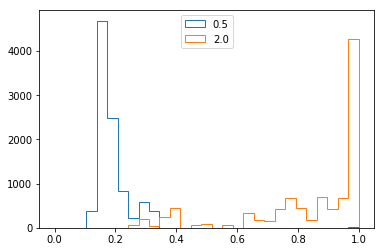

In [1015]:
_ = plt.hist([a[0] for a in pred05_test], 
             bins=np.linspace(0,1,30), histtype='step', label='0.5',
             weights=d_test[:]['weights_fsr05'])
_ = plt.hist([a[0] for a in pred20_test],
             bins=np.linspace(0,1,30), histtype='step', label='2.0',
             weights=d_test[:]['weights_fsr20'])
plt.legend(loc='upper center')

In [ ]:
# Training dataset

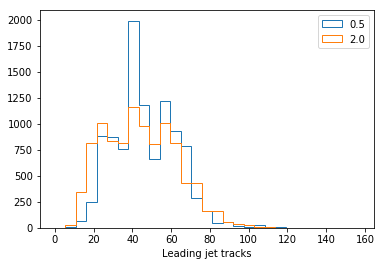

In [1062]:
bins = np.linspace(0, d[:]['nparticles'][:, 0].max(), 30)
_ = plt.hist(d[:]['nparticles'][:, 0], weights=d[:]['weights_fsr05'], histtype='step', bins=bins, #normed=True,
            label='0.5')
_ = plt.hist(d[:]['nparticles'][:, 0], weights=d[:]['weights_fsr20'], histtype='step', bins=bins, #normed=True,
            label='2.0')
plt.legend()
plt.xlabel('Leading jet tracks')

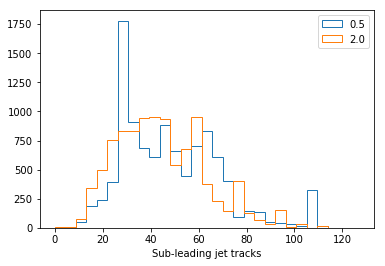

In [1054]:
bins = np.linspace(0, d[:]['nparticles'][:, 1].max(), 30)
_ = plt.hist(d[:]['nparticles'][:, 1], weights=d[:]['weights_fsr05'], histtype='step', bins=bins, #normed=True,
            label='0.5')
_ = plt.hist(d[:]['nparticles'][:, 1], weights=d[:]['weights_fsr20'], histtype='step', bins=bins, #normed=True,
            label='2.0')
plt.legend()
plt.xlabel('Sub-leading jet tracks')

In [ ]:
# Test dataset

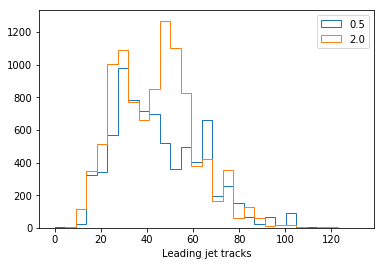

In [1063]:
bins = np.linspace(0, d_test[:]['nparticles'][:, 0].max(), 30)
_ = plt.hist(d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_fsr05'], histtype='step', bins=bins, #normed=True,
            label='0.5')
_ = plt.hist(d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_fsr20'], histtype='step', bins=bins, #normed=True,
            label='2.0')
plt.legend()
plt.xlabel('Leading jet tracks')

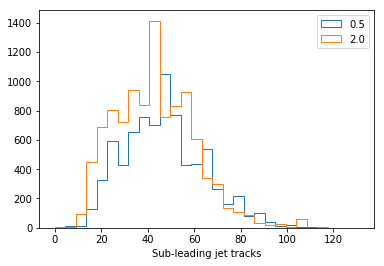

In [1064]:
bins = np.linspace(0, d_test[:]['nparticles'][:, 1].max(), 30)
_ = plt.hist(d_test[:]['nparticles'][:, 1], weights=d_test[:]['weights_fsr05'], histtype='step', bins=bins, #normed=True,
            label='0.5')
_ = plt.hist(d_test[:]['nparticles'][:, 1], weights=d_test[:]['weights_fsr20'], histtype='step', bins=bins, #normed=True,
            label='2.0')
plt.legend()
plt.xlabel('Sub-leading jet tracks')

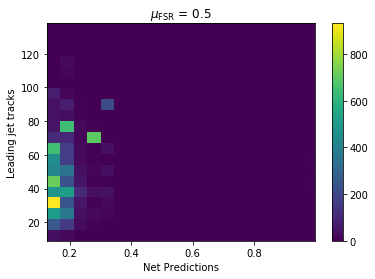

In [1018]:
_ = plt.hist2d([a[0] for a in pred05_test], d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_fsr05'][:, 0],
              bins=20)
plt.colorbar()
plt.title(r'$\mu_\mathrm{FSR}$ = 0.5')
plt.xlabel('Net Predictions')
plt.ylabel('Leading jet tracks')

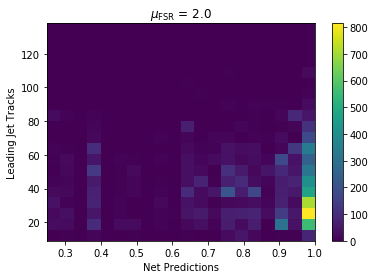

In [1019]:
_ = plt.hist2d([a[0] for a in pred20_test], d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_fsr20'][:, 0],
              bins=20)
plt.colorbar()
plt.title(r'$\mu_\mathrm{FSR}$ = 2.0')
plt.xlabel('Net Predictions')
plt.ylabel('Leading Jet Tracks')

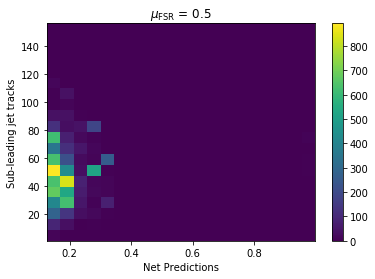

In [1020]:
_ = plt.hist2d([a[0] for a in pred05_test], d_test[:]['nparticles'][:, 1], weights=d_test[:]['weights_fsr05'][:, 0],
              bins=20)
plt.colorbar()
plt.title(r'$\mu_\mathrm{FSR}$ = 0.5')
plt.xlabel('Net Predictions')
plt.ylabel('Sub-leading jet tracks')

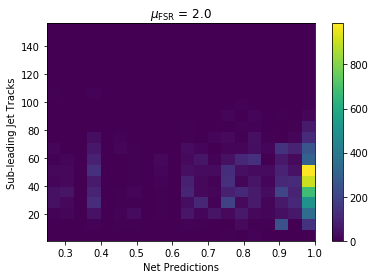

In [1021]:
_ = plt.hist2d([a[0] for a in pred20_test], d_test[:]['nparticles'][:, 1], weights=d_test[:]['weights_fsr20'][:, 0],
              bins=20)
plt.colorbar()
plt.title(r'$\mu_\mathrm{FSR}$ = 2.0')
plt.xlabel('Net Predictions')
plt.ylabel('Sub-leading Jet Tracks')

# n_tracks Classifier

In [1084]:
64*4

256

In [1085]:
class NTrackModel(nn.Module):

    def __init__(self, input_size):
        super(NTrackModel, self).__init__()

        self.dense = nn.Linear(input_size, 32)
        self.dropout = nn.Dropout(p=0.3)
        self.dense0 = nn.Linear(32, 64)
        self.dropout0 = nn.Dropout(p=0.3)
        self.dense1 = nn.Linear(64, 64)
        
        self.dense2 = nn.Linear(64 * 4, 32) # 4 is from the concat below
        self.dropout2 = nn.Dropout(p=0.1)
        self.dense3 = nn.Linear(32, 1)

    def forward(self, inputs, batch_weights, batch_size):

        hidden = F.relu(
            self.dense1(
                self.dropout0(
                    F.relu(
                        self.dense0(
                            self.dropout(
                                F.relu(
                                    self.dense(
                                        inputs))))))))

        batch_features = batch_weights.mm(hidden).expand(batch_size, hidden.shape[-1])
        
        weighted_mult = batch_weights.transpose(0, 1).expand(-1, hidden.shape[-1]) * hidden

        maxpool = torch.max(weighted_mult, 0)[0].expand(batch_size, -1)
        minpool = torch.min(weighted_mult, 0)[0].expand(batch_size, -1)
        avgpool = torch.mean(weighted_mult, 0).expand(batch_size, -1)
        
        batch_features = torch.cat([weighted_mult, maxpool, minpool, avgpool], 1)
        outputs = self.dense3(self.dropout2(F.relu(self.dense2(batch_features))))
        return outputs
        

In [1092]:
ntrackclassifier = NTrackModel(input_size=2)

In [1093]:
ntrackclassifier

NTrackModel(
  (dense): Linear(in_features=2, out_features=32)
  (dropout): Dropout(p=0.3)
  (dense0): Linear(in_features=32, out_features=64)
  (dropout0): Dropout(p=0.3)
  (dense1): Linear(in_features=64, out_features=64)
  (dense2): Linear(in_features=256, out_features=32)
  (dropout2): Dropout(p=0.1)
  (dense3): Linear(in_features=32, out_features=1)
)

In [1094]:
ntrackoptimizer = optim.SGD(ntrackclassifier.parameters(), lr=0.01)

In [1095]:
def ntrack_train_on_batch(model, optimizer, epoch, batch_idx, data, name_weights):
    
    inputs = Variable(data['nparticles'].type(torch.FloatTensor), requires_grad=False) # B x 2
    weights = torch.log(data[name_weights] / 1e-1).type(torch.FloatTensor)
    
    batch_size = inputs.shape[0]

    batch_weights = Variable(
            weights.resize_(1, batch_size),
            requires_grad=False) / torch.sum(weights) # normalized

    optimizer.zero_grad()
    predictions = model(inputs, batch_weights, batch_size)

    if name_weights == 'weights_fsr20':
        targets = Variable(torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
                          requires_grad=False)
    elif name_weights == 'weights_fsr05':
        targets = Variable(torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
                          requires_grad=False)
    else:
        raise ValueError
        
    loss_function = nn.BCEWithLogitsLoss() #nn.BCELoss() #weight=batch_weights)
    loss = loss_function(predictions, targets)
    loss.backward()
    optimizer.step()
    
    batch_weighted_loss = loss * batch_size # to compute per epoch loss

#     if batch_idx % 5 == 0:
#         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#             epoch,
#             dataloader.batch_size * batch_idx + len(data['leading_jet']),
#             len(dataloader.dataset),
#             100 * (dataloader.batch_size * batch_idx + len(data['leading_jet'])) / len(dataloader.dataset),
#             loss.data[0]))
    return batch_weighted_loss, np.array(model.dense.weight.data.numpy()[0]) # for debugging purposes

In [1096]:
best_loss = float('inf')
wait = 0
    
# time: 2 min and a half per epoch for training
for epoch in range(30): # n_epochs
    
    # training
    ntrackclassifier.train()
    
    # initialize per-epoch losses
    ntrack_batch_weighted_loss05_epoch = 0
    ntrack_batch_weighted_loss20_epoch = 0
    
    for batch_idx, data in enumerate(dataloader):
        
        ntrack_batch_weighted_loss05_i, _ = ntrack_train_on_batch(
            ntrackclassifier, ntrackoptimizer, epoch, batch_idx, data, 'weights_fsr05'
        )
        
        ntrack_batch_weighted_loss20_i, _ = ntrack_train_on_batch(
            ntrackclassifier, ntrackoptimizer, epoch, batch_idx, data, 'weights_fsr20'
        )
        
        # accumulate per-epoch loss
        ntrack_batch_weighted_loss05_epoch += ntrack_batch_weighted_loss05_i
        ntrack_batch_weighted_loss20_epoch += ntrack_batch_weighted_loss20_i
        
    print 'Epoch {}: Loss 0.5 = {}; Loss 2.0 = {}; Total = {}'.format(
        epoch,
        ntrack_batch_weighted_loss05_epoch.data[0] / dataloader.dataset.nevents,
        ntrack_batch_weighted_loss20_epoch.data[0] / dataloader.dataset.nevents,
        (ntrack_batch_weighted_loss05_epoch.data[0] + ntrack_batch_weighted_loss20_epoch.data[0]) / (2 * dataloader.dataset.nevents)
    )
    
    # validate
    ntrackclassifier.eval()
    loss_val = 0
    
    for batch_idx_val, data_val in enumerate(dataloader_val):
    
        inputs = Variable(data_val['nparticles'].type(torch.FloatTensor), requires_grad=False) # B x 2
        
        weights_05 = torch.log(data_val['weights_fsr05'] / 1e-1).type(torch.FloatTensor)
        weights_20 = torch.log(data_val['weights_fsr20'] / 1e-1).type(torch.FloatTensor)
        batch_size = inputs.shape[0]
        batch_weights_05 = Variable(
                weights_05.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_05) # normalized

        pred05_val = F.sigmoid(
            ntrackclassifier(inputs, batch_weights_05, batch_size))#.data.numpy()
        
        batch_weights_20 = Variable(
                weights_20.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_20) # normalized

        pred20_val = F.sigmoid(
            ntrackclassifier(inputs, batch_weights_20, batch_size))#.data.numpy()
        
        targets_05 = Variable(
            torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
            requires_grad=False)
        
        targets_20 = Variable(
            torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
            requires_grad=False)
        
        loss_function = nn.BCEWithLogitsLoss() 
        loss_val += (loss_function(pred05_val, targets_05) + loss_function(pred20_val, targets_20)) / 2
    
    loss_val /= (batch_idx_val + 1)
    loss_val = float(loss_val)
    # early stopping
    patience = 10
    if loss_val < best_loss:
        print 'Validation loss improved from {:0.5f} to {:0.5f}'.format(best_loss, loss_val)
        best_loss = loss_val
        wait = 0
        print 'Saving checkpoint at ./checkpoint_ntrack.pth'
        torch.save(ntrackclassifier.state_dict(), 'checkpoint_ntrack.pth')

    else:
        wait += 1
        if wait >= patience - 1:
            print 'Stopping early.'
            break
    
print 'Restoring best weights from checkpoint at ./checkpoint_ntrack.pth'
ntrackclassifier.load_state_dict(torch.load('checkpoint_ntrack.pth'))

# plt.plot(last_layer_weights05, color='blue', alpha=1 - 1./(1+epoch), label='0.5 - epoch: {}'.format(epoch))
# plt.plot(last_layer_weights20, color='orange', alpha=1 - 1./(1+epoch), label='2.0 - epoch: {}'.format(epoch))

# plt.legend()
# plt.show()

Epoch 0: Loss 0.5 = 0.765069970703; Loss 2.0 = 0.185357385254; Total = 0.475213677979
Validation loss improved from inf to 0.66411
Saving checkpoint at ./checkpoint_ntrack.pth
Epoch 1: Loss 0.5 = 0.582028076172; Loss 2.0 = 0.144829760742; Total = 0.363428918457
Epoch 2: Loss 0.5 = 0.602610595703; Loss 2.0 = 0.18307689209; Total = 0.392843743896
Epoch 3: Loss 0.5 = 0.526563671875; Loss 2.0 = 0.335785498047; Total = 0.431174584961
Validation loss improved from 0.66411 to 0.63538
Saving checkpoint at ./checkpoint_ntrack.pth
Epoch 4: Loss 0.5 = 0.507062451172; Loss 2.0 = 0.159271960449; Total = 0.333167205811
Validation loss improved from 0.63538 to 0.62121
Saving checkpoint at ./checkpoint_ntrack.pth
Epoch 5: Loss 0.5 = 0.399321777344; Loss 2.0 = 0.159263720703; Total = 0.279292749023
Validation loss improved from 0.62121 to 0.60354
Saving checkpoint at ./checkpoint_ntrack.pth
Epoch 6: Loss 0.5 = 0.35930690918; Loss 2.0 = 0.134146166992; Total = 0.246726538086
Validation loss improved fro

# Save model to ONNX

In [980]:
import torch.onnx

torch.onnx.export(model,
                  (leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size),
                  f='batchlevel.proto', verbose=True)

ValueError: NestedIOFunction doesn't know how to process an input object of type ndarray

In [53]:
from graphviz import Digraph


def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="50,50"))
    print dot
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [57]:
# g = make_dot(predictions, model.state_dict())
# g.view()

{4536365568: 'minibatch_tensor', 4536050752: 'lstm_lead.bias_hh_l0', 4498255744: 'lstm_lead.weight_ih_l0_reverse', 4536366504: 'lstm_sublead.bias_ih_l0_reverse', 4536365784: 'lstm_sublead.bias_hh_l0_reverse', 4535702088: 'lstm_lead.bias_ih_l0_reverse', 4535703744: 'lstm_lead.weight_hh_l0_reverse', 4536006704: 'lstm_lead.weight_ih_l0', 4535705400: 'lstm_lead.bias_hh_l0_reverse', 4536365424: 'lstm_sublead.weight_hh_l0_reverse', 4536366432: 'lstm_sublead.weight_ih_l0_reverse', 4536366360: 'lstm_sublead.bias_hh_l0', 4536368088: 'dense.bias', 4536050680: 'lstm_lead.weight_hh_l0', 4536368232: 'lstm_sublead.weight_hh_l0', 4536366720: 'lstm_sublead.bias_ih_l0', 4536367296: 'dense.weight', 4536368376: 'lstm_sublead.weight_ih_l0', 4536051472: 'lstm_lead.bias_ih_l0'}
digraph {
	graph [size="50,50"]
	node [align=left fontsize=12 height=0.2 ranksep=0.1 shape=box style=filled]
}


'Digraph.gv.pdf'